# Линейные модели

In [1]:
import random as pr
import numpy as np
import pandas as pd
import matplotlib.pylab as pl
import sklearn.cross_validation as cv
import sklearn.metrics as sm
from scipy.spatial.distance import cityblock
import math
import sys

# Plotting config
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [4]:
data = np.load("out_4_without_rts_and_replies.dat.npz")
users = data["users"]
X_dataset = data["data"].reshape(1,)[0]

In [5]:
TRAINING_SET_URL = "twitter_train.txt"
EXAMPLE_SET_URL = "twitter_example.txt"
df_users_train = pd.read_csv(TRAINING_SET_URL, sep=",", header=0, names=["uid", "cat"])
df_users_ex = pd.read_csv(EXAMPLE_SET_URL, sep=",", header=0, names=["uid", "cat"])
df_users_ex['cat'] = None
df_users = pd.concat([df_users_train, df_users_ex])
df_users = df_users.reset_index(drop=True)
df_users.head()

,uid,cat
0,40585382,1.0
1,30005269,0.0
2,3314758074,0.0
3,14311688,0.0
4,110457801,0.0


Модель строим для пользователей из twitter_train, нужно выбрать этих пользователей из матрицы из 4 ДЗ:

In [6]:
train_users = df_users_train['uid'].values
ix = np.in1d(users, train_users).reshape(users.shape)
X = X_dataset[np.where(ix)]

Формируем целевую переменную: Делаем join списка пользователей из ДЗ4 с обучающей выборкой.

In [7]:
Y = df_users_train['cat'].values
print "Resulting training set: (%dx%d) feature matrix, %d target vector" % (X.shape[0], X.shape[1], Y.shape[0])

Resulting training set: (5000x322133) feature matrix, 5000 target vector


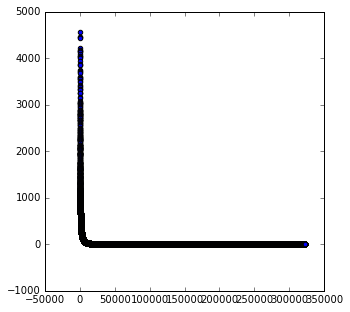

In [19]:
def draw_log_hist(x):
    """Draw tokens histogram in log scales"""
    # Your code here
    freq = np.array(((x!=0).sum(axis = 0)+1).tolist()[0])
    ran = xrange(1, x.shape[1]+1)
    plt.figure(figsize=(5, 5))
    #plt.xscale('log')
    #plt.yscale('log')
    plt.scatter(ran, sorted(freq, reverse=True))
    return freq

features_counts = draw_log_hist(X)

In [9]:
X1 = X.tocsc()[:, features_counts > 100].toarray()

In [10]:
USER_NAME = "i.denisov"
OPTIMIZATION_ALGORITHMS = ["stochastic gradient descent", "Newton method"]
REGULARIZATIONS = ["L1", "L2"]

print "My algorithm is: Logistic regression with %s regularization optimized by %s" % (
    REGULARIZATIONS[hash(USER_NAME) % 2],
    OPTIMIZATION_ALGORITHMS[hash(USER_NAME[::-1]) % 2]
)

My homework 5 algorithm is: Logistic regression with L1 regularization optimized by stochastic gradient descent


In [11]:
class LogisticRegression():

    def __init__(self, lambda_par = 1.0, alpha_par = 1.0, tol = 0.00001, n_iters = 20, output = False, regularization = True):
        self.tol = tol
        self.alpha_par = float(alpha_par) if alpha_par >= 0 else 1.0
        self.lambda_par = lambda_par if lambda_par >= 0 else 1.0
        self.n_iters = n_iters
        self.output = output
        self.regularization = regularization
    
    def fit(self, X, Y=None):        
        def sigmoid(z): #h(z)
            result = 1/(1+np.exp(-z))
            return result
        
        def cost_function(data, theta, clusters):
            m, n = data.shape
            if (self.regularization):
                regularization = (self.lambda_par / (2.0 * m)) * norm(theta[1:])
                #print norm(regularization)
            else:
                regularization = 0.0
            cost = (-1.0 / m) * np.sum((np.log(sigmoid(np.dot(data, theta))) * clusters) + \
                    (np.log(1.0 - sigmoid(np.dot(data, theta))) * (1.0 - clusters)))
            #J = (-1.0/ m) * ( np.sum( np.log(sigmoid( np.dot(data, theta))) * clusters + \
            #                    ( np.log ( 1 - sigmoid(np.dot(data, theta)) ) * ( 1 - clusters ) )))
            #add regularization
            cost = cost + regularization
            return cost
        
        def norm(vector):
            #L1 norm
            return np.sum(np.abs(vector))

        def stop_condition(old_theta, theta):
            if (norm(old_theta - theta) <= self.tol):
                return True
            else:
                return False
        """
        def new_theta(data, theta, clusters):
            m, n = data.shape
            #add regularization
            if self.regularization:
                lambda_par = self.lambda_par
            else:
                lambda_par = 0.0
            
            grad = np.zeros(n)
            A = (sigmoid(np.dot(data, theta)) - clusters )
            B =  data[:,0].reshape((data.shape[0],1))
            grad[0] = (self.alpha_par/m) * np.sum(A*B)
            for j in xrange(1, n):
                grad[j] = (self.alpha_par / m) * (np.sum(A * data[:,j]) + lambda_par * theta[j] / m)
            new_theta = theta - grad
            return new_theta
        """
        
        """
        def new_theta(data, theta, clusters):
            m,n = data.shape
            regularized = self.regularization
            if(regularized == True):
                lambda_par = self.lambda_par
            else:
                lambda_par = 0
            grad = np.zeros(n)
            A = sigmoid(np.dot(data, theta)) - clusters
            B =  data[:,0]
            grad[0] = (1.0 / m) * np.sum(A*B)

            A = sigmoid(np.dot(data,theta)) - clusters        
            for i in range(1, len(grad)):
                B = data[:,i]
                grad[i] = (1.0 / m) * np.sum(A*B) + ((lambda_par/m)*theta[i])
            new_theta = theta - (np.dot(self.alpha_par / m , grad))
            return new_theta
        """
        def new_theta(data, theta, clusters):
            m,n = data.shape
            regularized = self.regularization
            if(regularized == True):
                lambda_par = self.lambda_par
            else:
                lambda_par = 0
            grad = np.zeros(n)
            A = sigmoid(np.dot(data, theta)) - clusters
            grad = (1.0 / m) * (data.T.dot(A) + lambda_par * theta)
            B =  data[:,0]
            grad[0] = (1.0 / m) * np.sum(A*B)
            new_theta = theta - (np.dot(self.alpha_par / m , grad))
            return new_theta
        
        m, n = X.shape
        #add ones column at beginning for theta_0
        tmp = np.ones((m,1))
        data = np.append(tmp, X, axis=1)        
        m, n = data.shape
        clusters = Y
        theta = np.zeros(n)
        old_theta = np.zeros(n)
        for i in xrange(self.n_iters):
            old_theta = theta
            #theta = new_theta(data, theta, clusters)
            theta = new_theta(data, theta, clusters)
            if self.output:
                print "Cost", cost_function(data, theta, clusters), "Delta_theta",  norm(old_theta - theta)
            if stop_condition(old_theta, theta):
                break
        self.theta = theta
        print "Total: Cost", cost_function(data, theta, clusters), "Delta_theta",  norm(old_theta - theta)
        return self
        
    
    def predict_proba(self, X):
        def sigmoid(z): #h(z)
            result = 1.0 /(1.0+np.exp(-z))
            return result
        
        m, n = X.shape
        #add ones column at beginning for theta_0
        tmp = np.ones((m,1))
        data = np.append(tmp, X, axis=1)        
        m, n = data.shape
        result = sigmoid(np.dot(data, self.theta))
        return result

Реализуем метрику качества, используемую в соревновании: площадь под ROC кривой

In [12]:
def auroc(y_prob, y_true):
    pos_am = (y_true == 1).sum()
    neg_am = (y_true != 1).sum()
    #descending sort y_prob and y_true  
    descending_indexes = np.argsort(y_prob)[::-1]
    y_true_desc = y_true[descending_indexes]
    y_prob_desc = y_prob[descending_indexes]

    fp = 0
    tp = 0
    fpr = []
    tpr = []
    fprev = -inf
    auc = 0
    for i in xrange(len(y_true)):
        if y_true_desc[i] == 0:
            if i==0:
                fpr.append(1.0/neg_am)
                tpr.append(0.0)
            else:
                fpr.append(fpr[-1] + 1.0/neg_am)
                tpr.append(tpr[-1])
            auc = auc + 1.0 / neg_am * tpr[-1]
        else:
            if i==0:
                fpr.append(0.0)
                tpr.append(1.0/pos_am)
            else:
                fpr.append(fpr[-1])
                tpr.append(tpr[-1]+ 1.0/pos_am)
    return tpr, fpr, auc

In [13]:
def accuracy(y_prob, y_test):
    test = y_test == 1
    #print len(test)
    prob = y_prob >= 0.5
    #print len(prob)
    pos_result = np.array(test == prob)
    #print len(pos_result)
    return float(pos_result[pos_result == True].sum()) / len(y_test)

In [14]:
C = [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]

def select_reg_parameter(C, X, Y):
    kfolds = cv.KFold(n=len(Y), n_folds=5, shuffle=True, random_state=40)
    results = []
    for i, c in enumerate(C):
        print "################ Iteration №%d; C = %f ################" % (i, c)
        auc = []
        for j, (train_index, test_index) in enumerate(kfolds):
            print "Fold №%d of %d" % (j+1, len(kfolds))
            r = LogisticRegression(lambda_par = 1.0, n_iters=100, alpha_par = c, output=False, tol=0.0000001)
            r.fit(X[train_index],Y[train_index])
            y_prob = r.predict_proba(X[test_index])
            curr_auc = auroc(y_prob, Y[test_index])[2]
            curr_acc = accuracy(y_prob, Y[test_index])
            print "Accuracy", curr_acc
            print "AUC", curr_auc
            auc.append(curr_auc)
        results.append(np.mean(auc))
        print "Mean:", results
    return results.index(max(results))

index = select_reg_parameter(C, X1, Y)
print index

################ Iteration №0; C = 0.001000 ################
Fold №1 of 5
Total: Cost 0.693032077011 Delta_theta 7.38237537931e-06
Accuracy 0.665
AUC 0.715623862131
Fold №2 of 5
Total: Cost 0.693037046815 Delta_theta 7.58360303359e-06
Accuracy 0.637
AUC 0.706926827707
Fold №3 of 5
Total: Cost 0.693026706687 Delta_theta 7.64969827882e-06
Accuracy 0.642
AUC 0.682590921455
Fold №4 of 5
Total: Cost 0.693027344034 Delta_theta 7.78887865712e-06
Accuracy 0.622
AUC 0.690625563007
Fold №5 of 5
Total: Cost 0.69302484639 Delta_theta 7.74734655675e-06
Accuracy 0.588
AUC 0.667831454063
Mean: [0.69271972567260831]
################ Iteration №1; C = 0.010000 ################
Fold №1 of 5
Total: Cost 0.692014373808 Delta_theta 7.32943885332e-05
Accuracy 0.671
AUC 0.715699886763
Fold №2 of 5
Total: Cost 0.692062746633 Delta_theta 7.53805973853e-05
Accuracy 0.637
AUC 0.707170828683
Fold №3 of 5


KeyboardInterrupt: 

Выбираем наилучшее значение $C$, и классифицируем неизвестных пользователей и строим ROC-кривую

Total: Cost 0.603090046709 Delta_theta 0.0387438729152
Area under the ROC curve : 0.699381


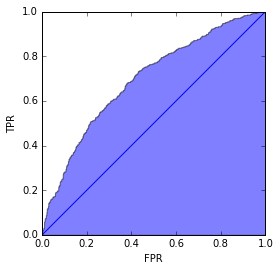

In [16]:
def classify(X, Y, test_size, C):
    model = LogisticRegression(lambda_par = 1.0, n_iters=100, alpha_par = C, output=False, tol=0.0000001)
    x_train, x_test, y_train, y_test = cv.train_test_split(X, Y, test_size=test_size)
    fit = model.fit(x_train, y_train)
    y_prob = fit.predict_proba(x_test)    
    return auroc(y_prob, y_test)   

tpr, fpr, roc_auc = classify(X1, Y, 0.3, C[index])

print "Area under the ROC curve : %f" % roc_auc

def plot_roc_curve(tpr, fpr, roc_auc): 
    """Plot ROC curve"""
    # Plot ROC curve
    plt.figure(figsize=(4,4))
    plt.fill_between(fpr, tpr, alpha=0.5)
    plt.plot([0, 1], [0, 1])
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    
plot_roc_curve(tpr, fpr, roc_auc)